In [ ]:
## model trainer for fuel consumption can based

In [2]:
! pip install matplotlib

## create a csv from the json files

In [211]:

import os
import json
import pandas as pd

folder_path = r'C:\Users\Admin\Documents\ProjectSetup\notebook\data\carbonx'
output_csv = r'C:\Users\Admin\Documents\ProjectSetup\notebook\data\real_data.csv'
def json_to_csv(folder_path, output_csv):
    all_data = []

    # Iterate over all JSON files in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith('.json'):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'r') as file:
                data = json.load(file)
                if isinstance(data, list):
                    all_data.extend(data)
                else:
                    all_data.append(data)

    # Create a DataFrame from the collected data
    df = pd.DataFrame(all_data)

    # Save DataFrame to a CSV file
    df.to_csv(output_csv, index=False)

    print(f"CSV file created at: {output_csv}")

# Usage
folder_path = folder_path  # replace with your folder path
output_csv = output_csv  # replace with your desired output file name

json_to_csv(folder_path, output_csv)

CSV file created at: C:\Users\Admin\Documents\ProjectSetup\notebook\data\real_data.csv


In [253]:
# Basic Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
# Modelling
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
#from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import warnings

df = pd.read_csv('data/real_data.csv')

df = df.drop(['unit_id','basic_ignition_total_duration', 'basic_ignition_moving_duration','country_code','lat','lng','lifetime_odo','last_update','lifetime_engine','created_at','from_timestamp','till_timestamp','reg_plate'], axis=1)

df.head()


,basic_moving_percentage,basic_km,basic_trips,basic_avg_speed,basic_ignition_total_duration_in_sec,basic_ignition_moving_duration_in_sec,basic_fuel_consumed,can_km,can_fuel_consumed,vehcile_model
0,0.68,176.81,4,22.50,15473.0,10499.300075,36.61,176.50,35.00,2013 / Volvo fh
1,0.69,295.19,11,21.73,26137.0,17976.926429,61.66,302.18,91.30,2014 Volvo fh
2,0.52,261.97,12,17.08,38299.0,20021.502916,56.16,272.13,103.59,2012 Volvo fh
3,0.65,442.84,15,26.73,45303.0,29643.465730,93.65,423.38,118.50,2014 Volvo fh
4,0.67,266.21,7,23.57,26190.0,17655.092745,55.71,256.87,83.10,2014 Volvo fh


In [254]:

df.shape

(65164, 10)

In [255]:
df.isna().sum()

basic_moving_percentage                      0
basic_km                                     0
basic_trips                                  0
basic_avg_speed                              0
basic_ignition_total_duration_in_sec         0
basic_ignition_moving_duration_in_sec        0
basic_fuel_consumed                          0
can_km                                   53964
can_fuel_consumed                        53964
vehcile_model                               33
dtype: int64

## Drop rows that do not have can_km and can_fuel

In [256]:
df.dropna(subset=['can_km','can_fuel_consumed'], inplace=True)
df.head()

,basic_moving_percentage,basic_km,basic_trips,basic_avg_speed,basic_ignition_total_duration_in_sec,basic_ignition_moving_duration_in_sec,basic_fuel_consumed,can_km,can_fuel_consumed,vehcile_model
0,0.68,176.81,4,22.50,15473.0,10499.300075,36.61,176.50,35.00,2013 / Volvo fh
1,0.69,295.19,11,21.73,26137.0,17976.926429,61.66,302.18,91.30,2014 Volvo fh
2,0.52,261.97,12,17.08,38299.0,20021.502916,56.16,272.13,103.59,2012 Volvo fh
3,0.65,442.84,15,26.73,45303.0,29643.465730,93.65,423.38,118.50,2014 Volvo fh
4,0.67,266.21,7,23.57,26190.0,17655.092745,55.71,256.87,83.10,2014 Volvo fh


Normalize the vehicle names to simplify and cluster it

In [257]:
import pandas as pd
import re

# Define the normalization function
def normalize_vehicle_description(vehicle):
    pattern = re.compile(r'(\d{4})\s*[/,-]?\s*(\w+)\s*(\w+)\s*(\d+)?', re.IGNORECASE)
    
    match = pattern.match(vehicle)
    if match:
        year, make, model, extra = match.groups()
        normalized = f"{year} {make.capitalize()} {model.upper()}"
        if extra:
            normalized += f" {extra}"
        return normalized.strip()
    else:
        # Handle cases without a year or different format
        parts = vehicle.split(',')
        if len(parts) > 1:
            return parts[1].strip() + " " + parts[0].strip()
        else:
            return vehicle.strip().capitalize()

# Example DataFrame


# Apply the normalization function to the DataFrame column
df['normalized_vehcile_model'] = df['vehcile_model'].apply(normalize_vehicle_description)



In [258]:
df.describe()

,basic_moving_percentage,basic_km,basic_trips,basic_avg_speed,basic_ignition_total_duration_in_sec,basic_ignition_moving_duration_in_sec,basic_fuel_consumed,can_km,can_fuel_consumed
count,11200.000000,11200.000000,11200.000000,11200.000000,11200.000000,11200.000000,11200.000000,11200.000000,11200.000000
mean,1.607166,227.093179,8.008929,26.531521,26021.543929,14521.433332,44.648897,223.076355,75.454266
std,55.106043,192.996379,5.906519,239.710581,19288.012302,11886.597470,126.106736,232.164119,100.331273
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-9426.140000,0.000000,-4175.700000
25%,0.130000,32.482500,4.000000,13.085000,7834.500000,2023.253766,6.427500,3.410000,3.765000
50%,0.500000,211.275000,8.000000,24.220000,26133.000000,14121.451195,44.105000,193.750000,68.000000
75%,0.670000,360.707500,11.000000,32.000000,40693.750000,23139.958485,75.732500,352.250000,129.955000
max,4579.700000,1282.560000,38.000000,24971.000000,82268.000000,66273.147790,251.720000,1987.630000,419.700000


In [259]:

df_new = df[(df['can_fuel_consumed'] >= 0) & (df['basic_fuel_consumed'] >= 0)]
df_new

,basic_moving_percentage,basic_km,basic_trips,basic_avg_speed,basic_ignition_total_duration_in_sec,basic_ignition_moving_duration_in_sec,basic_fuel_consumed,can_km,can_fuel_consumed,vehcile_model,normalized_vehcile_model
0,0.68,176.81,4,22.50,15473.0,10499.300075,36.61,176.50,35.00,2013 / Volvo fh,2013 Volvo FH
1,0.69,295.19,11,21.73,26137.0,17976.926429,61.66,302.18,91.30,2014 Volvo fh,2014 Volvo FH
2,0.52,261.97,12,17.08,38299.0,20021.502916,56.16,272.13,103.59,2012 Volvo fh,2012 Volvo FH
3,0.65,442.84,15,26.73,45303.0,29643.465730,93.65,423.38,118.50,2014 Volvo fh,2014 Volvo FH
4,0.67,266.21,7,23.57,26190.0,17655.092745,55.71,256.87,83.10,2014 Volvo fh,2014 Volvo FH
...,...,...,...,...,...,...,...,...,...,...,...
64862,0.52,189.99,32,40.34,27433.0,14278.719408,41.50,0.00,0.00,Unicorn Honda,Unicorn honda
64863,0.70,256.59,21,26.86,29656.0,20836.157834,54.91,0.00,23.20,TOYOTA RUSH 2022,Toyota rush 2022
64864,0.44,220.00,24,31.67,27745.0,12270.742488,47.27,0.00,22.40,Toyota rush 2022,Toyota rush 2022
64865,0.73,225.35,21,31.90,28063.0,20349.111936,48.58,0.00,21.40,Toyota rush 2022,Toyota rush 2022


In [260]:
df_new.describe()

,basic_moving_percentage,basic_km,basic_trips,basic_avg_speed,basic_ignition_total_duration_in_sec,basic_ignition_moving_duration_in_sec,basic_fuel_consumed,can_km,can_fuel_consumed
count,11149.000000,11149.000000,11149.000000,11149.000000,11149.000000,11149.000000,11149.000000,11149.000000,11149.000000
mean,0.523753,226.672703,8.009956,26.504266,26130.609023,14492.830422,47.465112,222.568069,76.384287
std,0.926215,193.018300,5.910360,240.256622,19259.105758,11887.544271,40.145223,231.808945,72.324525
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.120000,31.920000,4.000000,13.000000,8107.000000,1940.186683,6.790000,3.160000,3.600000
50%,0.490000,210.720000,8.000000,24.200000,26271.000000,14044.774896,44.310000,193.250000,67.600000
75%,0.670000,360.680000,11.000000,32.000000,40750.000000,23139.093204,75.840000,352.130000,129.700000
max,30.170000,1282.560000,38.000000,24971.000000,82268.000000,66273.147790,251.720000,1987.630000,419.700000


In [261]:
df_new.shape

(11149, 11)

How to filter outliers

In [262]:
df.nunique()

basic_moving_percentage                   378
basic_km                                 8298
basic_trips                                36
basic_avg_speed                          2541
basic_ignition_total_duration_in_sec     8920
basic_ignition_moving_duration_in_sec    8531
basic_fuel_consumed                      6344
can_km                                   6384
can_fuel_consumed                        5063
vehcile_model                              36
normalized_vehcile_model                   24
dtype: int64

In [263]:
# define numerical & categorical columns
numeric_features = [feature for feature in df_new.columns if df_new[feature].dtype != 'O']
categorical_features = [feature for feature in df_new.columns if df_new[feature].dtype == 'O']

# print columns
print('We have {} numerical features : {}'.format(len(numeric_features), numeric_features))
print('\nWe have {} categorical features : {}'.format(len(categorical_features), categorical_features))

We have 9 numerical features : ['basic_moving_percentage', 'basic_km', 'basic_trips', 'basic_avg_speed', 'basic_ignition_total_duration_in_sec', 'basic_ignition_moving_duration_in_sec', 'basic_fuel_consumed', 'can_km', 'can_fuel_consumed']

We have 2 categorical features : ['vehcile_model', 'normalized_vehcile_model']


In [265]:
print("Categories in 'normalized_vehcile_model' variable:     ",end=" " )
print(df_new['normalized_vehcile_model'].unique())




Categories in 'normalized_vehcile_model' variable:      ['2013 Volvo FH' '2014 Volvo FH' '2012 Volvo FH' '2004 Volvo FH12'
 '2008 Volvo FH12' '2008 Volvo FH' '2010 Volvo FH' '2007 Volvo FH12'
 '2011 Volvo FH' '2020 Toyota Avanza' '2020 Ford transit'
 'Renault symbol 2020' 'Toyota avanza 2020' 'Toyota rush 2022'
 'Renault symbol' 'Toyota hiace' 'Ford transit 2020' 'Unicorn honda'
 '2014 Volvo FH 420' '2005 Volvo FH12' '2015 Volvo FH' '2015 Volvo FH12'
 'Volvo fh420' '2016 Volvo FH']


In [266]:

df_new['mileage'] = df_new['can_km'] / df_new['can_fuel_consumed'] 

C:\Users\Admin\AppData\Local\Temp\ipykernel_9516\1291727200.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['mileage'] = df_new['can_km'] / df_new['can_fuel_consumed']


In [267]:
df_new.head()

,basic_moving_percentage,basic_km,basic_trips,basic_avg_speed,basic_ignition_total_duration_in_sec,basic_ignition_moving_duration_in_sec,basic_fuel_consumed,can_km,can_fuel_consumed,vehcile_model,normalized_vehcile_model,mileage
0,0.68,176.81,4,22.50,15473.0,10499.300075,36.61,176.50,35.00,2013 / Volvo fh,2013 Volvo FH,5.042857
1,0.69,295.19,11,21.73,26137.0,17976.926429,61.66,302.18,91.30,2014 Volvo fh,2014 Volvo FH,3.309748
2,0.52,261.97,12,17.08,38299.0,20021.502916,56.16,272.13,103.59,2012 Volvo fh,2012 Volvo FH,2.626991
3,0.65,442.84,15,26.73,45303.0,29643.465730,93.65,423.38,118.50,2014 Volvo fh,2014 Volvo FH,3.572827
4,0.67,266.21,7,23.57,26190.0,17655.092745,55.71,256.87,83.10,2014 Volvo fh,2014 Volvo FH,3.091095


In [268]:
df_new.describe()

c:\Users\Admin\Documents\ProjectSetup\venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,basic_moving_percentage,basic_km,basic_trips,basic_avg_speed,basic_ignition_total_duration_in_sec,basic_ignition_moving_duration_in_sec,basic_fuel_consumed,can_km,can_fuel_consumed,mileage
count,11149.000000,11149.000000,11149.000000,11149.000000,11149.000000,11149.000000,11149.000000,11149.000000,11149.000000,9630.000000
mean,0.523753,226.672703,8.009956,26.504266,26130.609023,14492.830422,47.465112,222.568069,76.384287,inf
std,0.926215,193.018300,5.910360,240.256622,19259.105758,11887.544271,40.145223,231.808945,72.324525,NaN
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.120000,31.920000,4.000000,13.000000,8107.000000,1940.186683,6.790000,3.160000,3.600000,1.991561
50%,0.490000,210.720000,8.000000,24.200000,26271.000000,14044.774896,44.310000,193.250000,67.600000,2.639540
75%,0.670000,360.680000,11.000000,32.000000,40750.000000,23139.093204,75.840000,352.130000,129.700000,3.408334
max,30.170000,1282.560000,38.000000,24971.000000,82268.000000,66273.147790,251.720000,1987.630000,419.700000,inf


In [269]:
df_new.isna()

,basic_moving_percentage,basic_km,basic_trips,basic_avg_speed,basic_ignition_total_duration_in_sec,basic_ignition_moving_duration_in_sec,basic_fuel_consumed,can_km,can_fuel_consumed,vehcile_model,normalized_vehcile_model,mileage
0,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
64862,False,False,False,False,False,False,False,False,False,False,False,True
64863,False,False,False,False,False,False,False,False,False,False,False,False
64864,False,False,False,False,False,False,False,False,False,False,False,False
64865,False,False,False,False,False,False,False,False,False,False,False,False


In [270]:
df_new.dropna()
#df_filtered= df[np.isfinite(df_new).all(1)]

,basic_moving_percentage,basic_km,basic_trips,basic_avg_speed,basic_ignition_total_duration_in_sec,basic_ignition_moving_duration_in_sec,basic_fuel_consumed,can_km,can_fuel_consumed,vehcile_model,normalized_vehcile_model,mileage
0,0.68,176.81,4,22.50,15473.0,10499.300075,36.61,176.50,35.00,2013 / Volvo fh,2013 Volvo FH,5.042857
1,0.69,295.19,11,21.73,26137.0,17976.926429,61.66,302.18,91.30,2014 Volvo fh,2014 Volvo FH,3.309748
2,0.52,261.97,12,17.08,38299.0,20021.502916,56.16,272.13,103.59,2012 Volvo fh,2012 Volvo FH,2.626991
3,0.65,442.84,15,26.73,45303.0,29643.465730,93.65,423.38,118.50,2014 Volvo fh,2014 Volvo FH,3.572827
4,0.67,266.21,7,23.57,26190.0,17655.092745,55.71,256.87,83.10,2014 Volvo fh,2014 Volvo FH,3.091095
...,...,...,...,...,...,...,...,...,...,...,...,...
64858,0.32,78.58,16,21.69,12849.0,4114.306276,17.29,1499.44,8.20,Toyota Rush 2022,Toyota rush 2022,182.858537
64861,0.55,98.45,6,33.67,9642.0,5311.379572,20.60,98.35,0.00,Ford Transit 2020,Ford transit 2020,inf
64863,0.70,256.59,21,26.86,29656.0,20836.157834,54.91,0.00,23.20,TOYOTA RUSH 2022,Toyota rush 2022,0.000000
64864,0.44,220.00,24,31.67,27745.0,12270.742488,47.27,0.00,22.40,Toyota rush 2022,Toyota rush 2022,0.000000


In [271]:
df_new=df_new[df_new.replace([np.inf, -np.inf], np.nan).notnull().all(axis=1)]

In [272]:
df_new.shape

(9178, 12)

In [273]:
y= df_new['can_fuel_consumed']
y

0         35.00
1         91.30
2        103.59
3        118.50
4         83.10
          ...  
64857      0.20
64858      8.20
64863     23.20
64864     22.40
64865     21.40
Name: can_fuel_consumed, Length: 9178, dtype: float64

In [274]:
X = df_new.drop(columns=['can_fuel_consumed'],axis=1)
X.head()

,basic_moving_percentage,basic_km,basic_trips,basic_avg_speed,basic_ignition_total_duration_in_sec,basic_ignition_moving_duration_in_sec,basic_fuel_consumed,can_km,vehcile_model,normalized_vehcile_model,mileage
0,0.68,176.81,4,22.50,15473.0,10499.300075,36.61,176.50,2013 / Volvo fh,2013 Volvo FH,5.042857
1,0.69,295.19,11,21.73,26137.0,17976.926429,61.66,302.18,2014 Volvo fh,2014 Volvo FH,3.309748
2,0.52,261.97,12,17.08,38299.0,20021.502916,56.16,272.13,2012 Volvo fh,2012 Volvo FH,2.626991
3,0.65,442.84,15,26.73,45303.0,29643.465730,93.65,423.38,2014 Volvo fh,2014 Volvo FH,3.572827
4,0.67,266.21,7,23.57,26190.0,17655.092745,55.71,256.87,2014 Volvo fh,2014 Volvo FH,3.091095


In [275]:
# Create Column Transformer with 3 types of transformers
num_features = X.select_dtypes(exclude="object").columns
cat_features = X.select_dtypes(include="object").columns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", oh_transformer, cat_features),
         ("StandardScaler", numeric_transformer, num_features),        
    ]
)

In [276]:
X = preprocessor.fit_transform(X)

In [277]:
X.shape

(9178, 58)

In [278]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train.shape, X_test.shape

((7342, 58), (1836, 58))

In [279]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [287]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(), 
   # "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor()
}

params={
                "Decision Tree": {
                    'criterion':['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
                    # 'splitter':['best','random'],
                    # 'max_features':['sqrt','log2'],
                },
                "Random Forest":{
                    # 'criterion':['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
                 
                    # 'max_features':['sqrt','log2',None],
                    'n_estimators': [8,16,32,64,128,256]
                },
                "Gradient Boosting":{
                    # 'loss':['squared_error', 'huber', 'absolute_error', 'quantile'],
                    'learning_rate':[.1,.01,.05,.001],
                    'subsample':[0.6,0.7,0.75,0.8,0.85,0.9],
                    # 'criterion':['squared_error', 'friedman_mse'],
                    # 'max_features':['auto','sqrt','log2'],
                    'n_estimators': [8,16,32,64,128,256]
                },
                "Linear Regression":{},
                "XGBRegressor":{
                    'learning_rate':[.1,.01,.05,.001],
                    'n_estimators': [8,16,32,64,128,256]
                },
                "CatBoosting Regressor":{
                    'depth': [6,8,10],
                    'learning_rate': [0.01, 0.05, 0.1],
                    'iterations': [30, 50, 100]
                },
                "AdaBoost Regressor":{
                    'learning_rate':[.1,.01,0.5,.001],
                    # 'loss':['linear','square','exponential'],
                    'n_estimators': [8,16,32,64,128,256]
                }
                
            }


model_list = []
r2_list =[]
rmse_list=[]
mae_list=[]

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Evaluate Train and Test dataset
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)

    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

    
    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)
    rmse_list.append(model_test_rmse)
    mae_list.append(model_test_mae)

    print('='*35)
    print('\n')

Linear Regression
Model performance for Training set
- Root Mean Squared Error: 22.0104
- Mean Absolute Error: 16.5238
- R2 Score: 0.8985
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 23.2529
- Mean Absolute Error: 17.1460
- R2 Score: 0.8931


Lasso
Model performance for Training set
- Root Mean Squared Error: 26.1866
- Mean Absolute Error: 19.4397
- R2 Score: 0.8564
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 26.7926
- Mean Absolute Error: 19.6463
- R2 Score: 0.8581


Ridge
Model performance for Training set
- Root Mean Squared Error: 22.0136
- Mean Absolute Error: 16.5277
- R2 Score: 0.8985
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 23.3122
- Mean Absolute Error: 17.1626
- R2 Score: 0.8925


K-Neighbors Regressor
Model performance for Training set
- Root Mean Squared Error: 15.9262
- Mean Absolute Error: 10.4417
- R2 Score: 0.9469
---------

In [288]:

pd.DataFrame(list(zip(model_list, r2_list,rmse_list,mae_list)), columns=['Model Name', 'R2_Score','RMSE_Score','MAE_Score']).sort_values(by=["R2_Score"],ascending=False)

,Model Name,R2_Score,RMSE_Score,MAE_Score
6,XGBRegressor,0.991800,6.439817,2.975710
5,Random Forest Regressor,0.990473,6.941317,2.287049
4,Decision Tree,0.982764,9.336650,3.882446
3,K-Neighbors Regressor,0.916897,20.501223,13.037834
0,Linear Regression,0.893092,23.252929,17.146037
2,Ridge,0.892546,23.312192,17.162623
1,Lasso,0.858067,26.792567,19.646280
7,AdaBoost Regressor,0.850428,27.504056,23.333239


In [282]:
lin_model = XGBRegressor(fit_intercept=True)
#lin_model = RandomForestRegressor()
lin_model = lin_model.fit(X_train, y_train)
y_pred = lin_model.predict(X_test)
score = r2_score(y_test, y_pred)*100
print(" Accuracy of the model is %.2f" %score)

 Accuracy of the model is 99.18


c:\Users\Admin\Documents\ProjectSetup\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:52:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "fit_intercept" } are not used.

  warnings.warn(smsg, UserWarning)


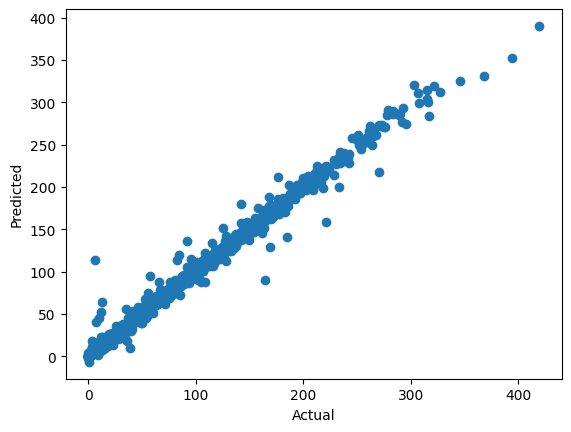

In [283]:
plt.scatter(y_test,y_pred);
plt.xlabel('Actual');
plt.ylabel('Predicted');

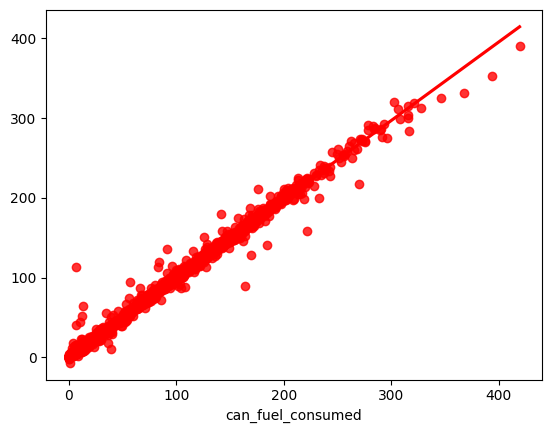

In [284]:
sns.regplot(x=y_test,y=y_pred,ci=None,color ='red');

In [285]:
pred_df=pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred,'Difference':y_test-y_pred})
pred_df

,Actual Value,Predicted Value,Difference
4543,83.59,86.108826,-2.518826
35067,197.60,201.721283,-4.121283
14977,139.61,139.651291,-0.041291
44676,4.30,3.813127,0.486873
47025,166.22,169.686798,-3.466798
...,...,...,...
42945,58.70,60.668961,-1.968961
29308,127.31,130.632965,-3.322965
47732,124.00,124.116356,-0.116356
332,120.60,118.969742,1.630258


In [286]:
pred_df.describe()

,Actual Value,Predicted Value,Difference
count,1836.000000,1836.000000,1836.000000
mean,91.765871,91.734955,0.030913
std,71.136159,70.380875,6.441497
min,0.090000,-6.755661,-107.303761
25%,21.900000,22.036109,-1.469832
50%,91.090000,90.816902,-0.014654
75%,140.357500,140.601719,1.791005
max,419.190000,390.133118,74.381557



Actual Value	Predicted Value	Difference
count	1836.000000	1836.000000	1836.000000
mean	91.765871	91.883247	-0.117370
std	71.136159	70.531364	6.503496
min	0.090000	-3.159507	-103.459500
25%	21.900000	21.894032	-1.601171
50%	91.090000	91.557690	-0.006729
75%	140.357500	140.681999	1.647881
max	419.190000	401.936646	80.290988


Actual Value	Predicted Value	Difference
count	1836.000000	1836.000000	1836.000000
mean	91.765871	92.038780	-0.272909
std	71.136159	70.505752	6.939719
min	0.090000	0.101000	-124.855900
25%	21.900000	21.700750	-0.680750
50%	91.090000	91.017900	-0.046900
75%	140.357500	140.654600	0.653550
max	419.190000	374.104900	75.588700

